In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


dataset_root = '/content/drive/MyDrive/빅데이터응용보안'
train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')
# Original KDD dataset feature names obtained from
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 'success_pred']

# Differentiating between nominal, binary, and numeric features

# root_shell is marked as a continuous feature in the kddcup.names
# file, but it is supposed to be a binary feature according to the
# dataset documentation

col_names = np.array(header_names)

nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))

nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types

category = defaultdict(list)
category['benign'].append('normal')

with open('/content/drive/MyDrive/빅데이터응용보안/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)

attack_mapping = dict((v,k) for k in category for v in category[k])

In [3]:
train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)

test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()
test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

In [4]:
# Wait a minute... the su_attempted column has a max value of 2.0?

train_df.groupby(['su_attempted']).size()
# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0

train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()
# Next, we notice that the num_outbound_cmds column only takes on one value!

train_df.groupby(['num_outbound_cmds']).size()
# Now, that's not a very useful feature - let's drop it from the dataset

train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

In [5]:
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)

combined_df_raw = pd.concat([train_x_raw, test_x_raw])
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

## **Few-shot learning**
출처: Y. Yu and N. Bian, "An Intrusion Detection Method Using Few-Shot Learning," in IEEE Access, vol. 8, pp. 49730-49740, 2020, doi: 10.1109/ACCESS.2020.2980136.

### 1~2. Model Framework

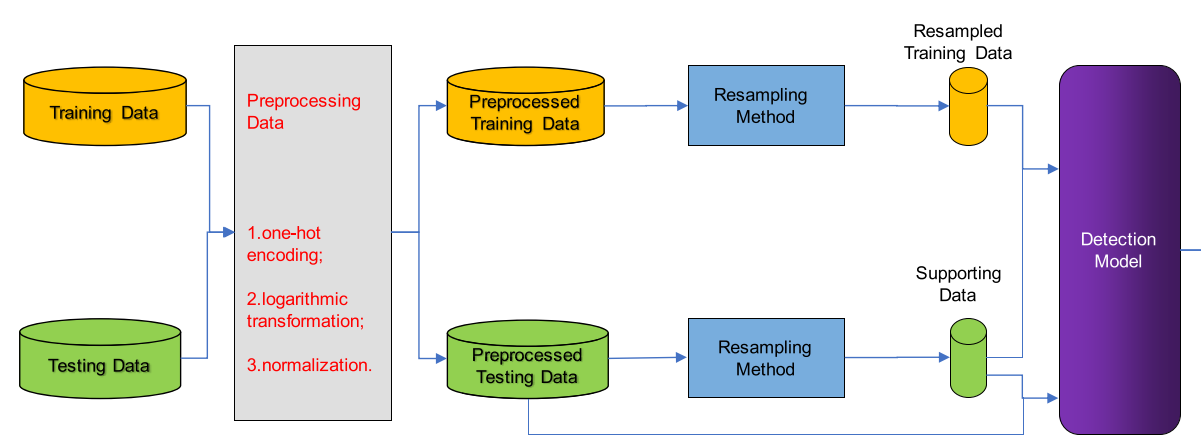

### 1. Preprocessing Data

1. 3 non-numeric features & 37 numeric features
2. one-hot encoding

* Final NSL-KDD feature: 121-dimensional
* 논문에서는 121 dimension이지만, 내가 처리한 데이터는 118 dimension이기 때문에 121(11*11 pixel)로 만들어주기 위해 3만큼 0-padding을 해줌.
3. logarithm transformation :  log (xi + 1)
* similarity assessment를 위해
* compress the range of large numbers and extend the range of small numbers
4. normalization (Min-max Scaler)

### 2. THE RESAMPLED TRAINING DATASET

* the samples training set was balanced by **resampling.**

* For the multi-class classiﬁcation experiment, we selected 50 samples and sampled them ten times for each class. The sampled **2500 (5 ∗ 50 ∗ 10) samples** were used as the new training dataset.

* 50 sample인 이유는 train set에서 가장 적은 모수를 가진 label인 'u2r'이 52개의 case밖에 없기 때문이다.

### 3~6. Testing phase for Multi-class classification

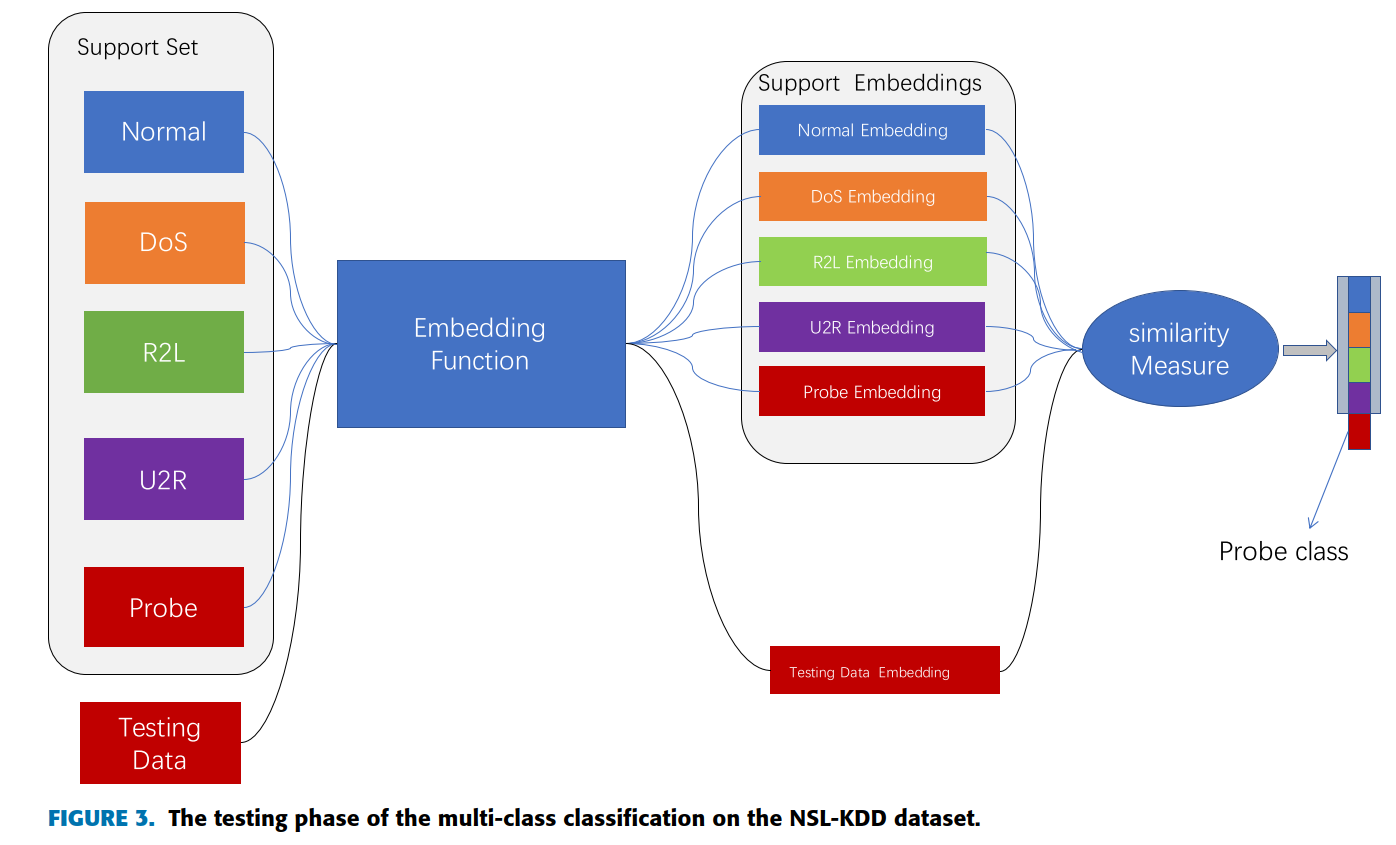

### 3. THE CHOICE OF SUPPORT SET

* Selecting samples from the training set as our support set, we randomly selected some samples from each class as the support set from the testing set -> 논문에서는 testing set에서 support set을 학습하였지만, 실제 구현한 결과 이는 overfitting이 과도하게 되었고, support set을 test set에서 학습한다면 NSL-KDD 데이터셋의 목적 자체가 label 분포가 다른 train, test에서 train 데이터셋을 학습하여 test를 잘 예측해보자는, generalization 평가의 목적을 잃을 것 같아 **training dataset**에서 support set을 뽑기로 하였다.
*  NSL-KDD multi-class clas-siﬁcation experiment, we selected **50 samples(5*10 samples per class)** from the test set as the support set. The support set only accounted for 0.22% of the testing set, but the accuracy has been improved by 4%.

### 4. Embedding Function: CNN

* 3 layers
* filter : 3*3 (commonly use)
* Parameter:
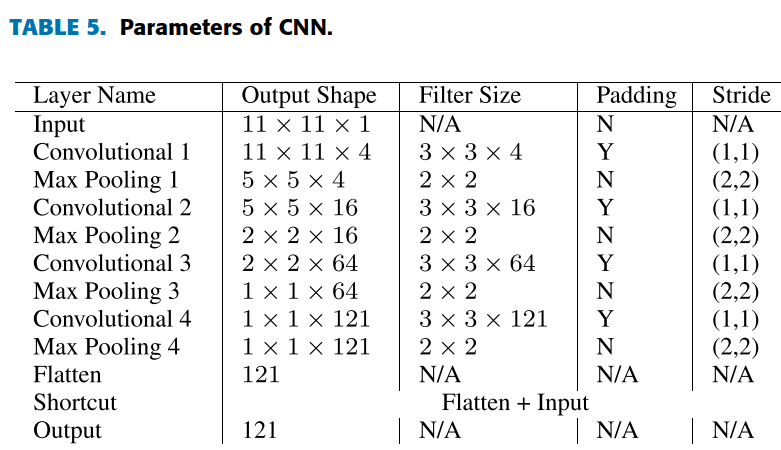

### 5. Similarity Measurement : Cosine similarity
* 논문에서는 Center Loss + Cosine similarity
* 하지만 구현 중 center loss를 similarity measure로 사용하는 법을 모르겠어서 **cosine 유사도**만 사용

### 6. Training episode : algorithm 1
* minimize loss function via gradientdescent

#### **Loss function**: **softmax + \lambda • Center loss**
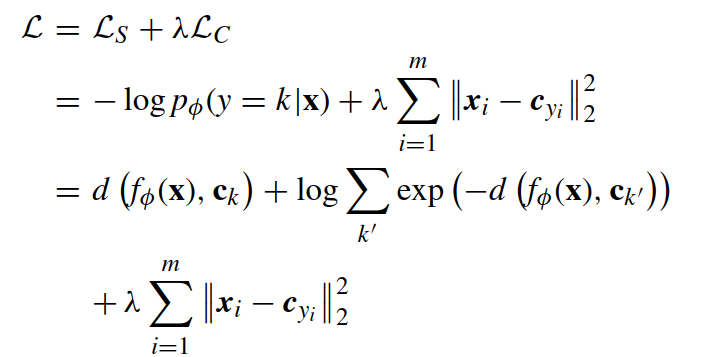

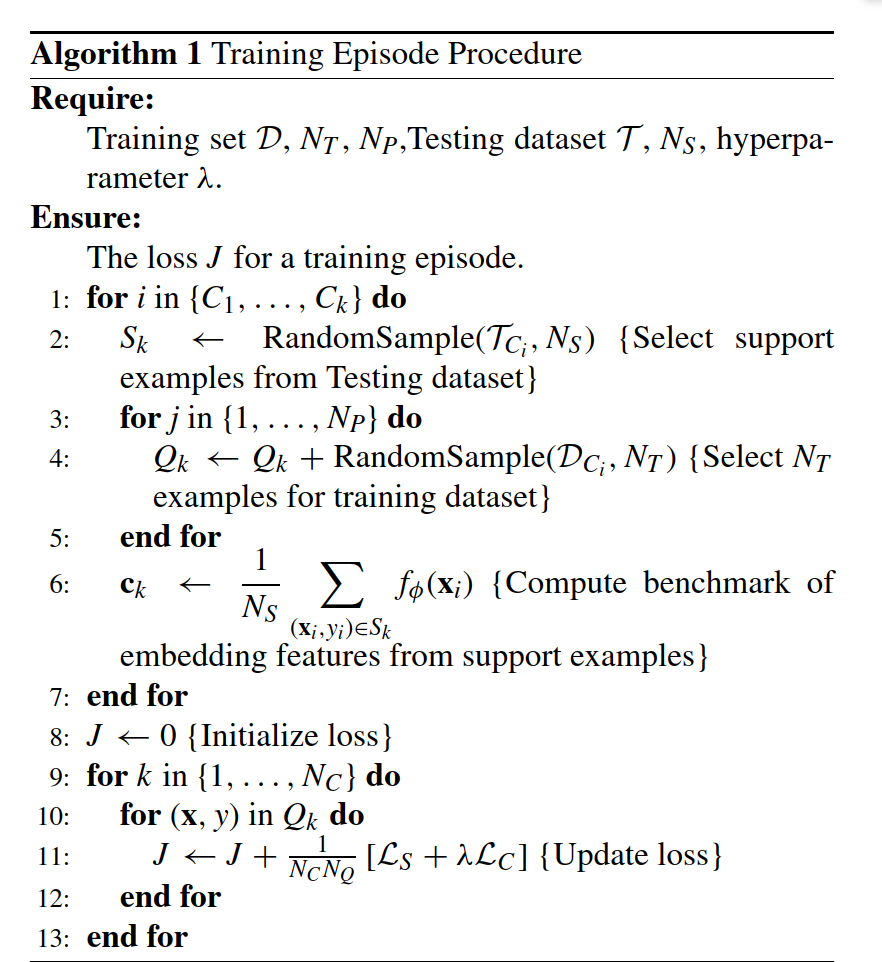

## Model summary

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torchsummary import summary

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# CNN Model Definition with Residual Blocks
class CNNModel(nn.Module):
    def __init__(self, input_shape, embedding_dim=121, num_classes=5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)

        # Adding Residual Blocks with reduced downsampling
        self.res_block1 = ResidualBlock(4, 16, stride=1)
        self.res_block2 = ResidualBlock(16, 64, stride=1)
        self.res_block3 = ResidualBlock(64, 121, stride=1)

        # Only one pooling layer after initial conv and res blocks
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output after the residual blocks
        self._to_linear = None
        self.convs(torch.randn(1, *input_shape))

        self.fc = nn.Linear(self._to_linear, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def convs(self, x):
        x = F.relu(self.conv1(x))           # Initial conv
        x = self.pool(x)                    # Pooling after initial conv
        x = self.res_block1(x)              # Residual block 1
        x = self.res_block2(x)              # Residual block 2
        x = self.res_block3(x)              # Residual block 3
        x = self.pool(x)                    # Pooling after res_block3

        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        embeddings = F.relu(self.fc(x))
        outputs = self.classifier(embeddings)
        return embeddings, outputs

input_shape = (1, 11,11)  # Example input shape for MNIST dataset
# Ensure the model and summary input are on the same device (CPU for this example)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print model summary
summary(model, input_size=input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 11, 11]              40
         MaxPool2d-2              [-1, 4, 5, 5]               0
            Conv2d-3             [-1, 16, 5, 5]             576
       BatchNorm2d-4             [-1, 16, 5, 5]              32
            Conv2d-5             [-1, 16, 5, 5]           2,304
       BatchNorm2d-6             [-1, 16, 5, 5]              32
            Conv2d-7             [-1, 16, 5, 5]              64
       BatchNorm2d-8             [-1, 16, 5, 5]              32
     ResidualBlock-9             [-1, 16, 5, 5]               0
           Conv2d-10             [-1, 64, 5, 5]           9,216
      BatchNorm2d-11             [-1, 64, 5, 5]             128
           Conv2d-12             [-1, 64, 5, 5]          36,864
      BatchNorm2d-13             [-1, 64, 5, 5]             128
           Conv2d-14             [-1, 6

#     lambda_ = 0.1     epochs = 5

Epoch 1/5
Training loss for episode: 9.943852820205688
Training loss for episode: 5.14321815700531
Training loss for episode: 2.9843563468933105
Training loss for episode: 2.111608107852936
Training loss for episode: 1.786328730392456
Training loss for episode: 1.675871074295044
Training loss for episode: 1.639453208732605
Training loss for episode: 1.6273682792663575
Training loss for episode: 1.6240566998481751
Training loss for episode: 1.6235612175941467
Epoch 1/5, Average Loss: 3.015967464208603
Epoch 2/5
Training loss for episode: 1.623542279434204
Training loss for episode: 1.6235437134742736
Training loss for episode: 1.6235445989608766
Training loss for episode: 1.6235451018333436
Training loss for episode: 1.623545442867279
Training loss for episode: 1.6235458245277405
Training loss for episode: 1.6235459210395813
Training loss for episode: 1.6235460259437562
Training loss for episode: 1.6235458177566529
Training loss for episode: 1.6235458054542542
Epoch 2/5, Average Loss: 1

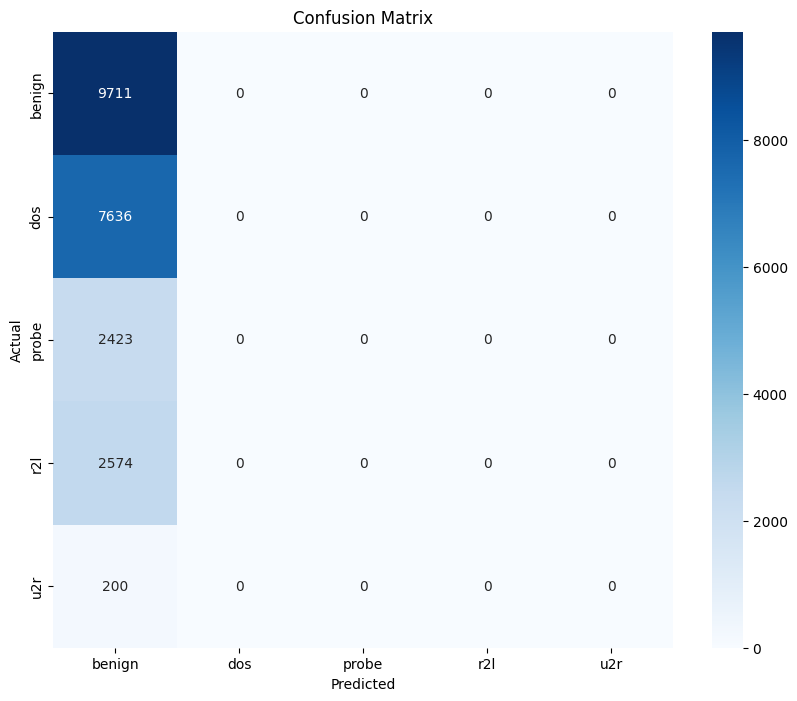

              precision    recall  f1-score   support

      benign       0.43      1.00      0.60      9711
         dos       0.00      0.00      0.00      7636
       probe       0.00      0.00      0.00      2423
         r2l       0.00      0.00      0.00      2574
         u2r       0.00      0.00      0.00       200

    accuracy                           0.43     22544
   macro avg       0.09      0.20      0.12     22544
weighted avg       0.19      0.43      0.26     22544

Zero-One Loss: 0.5692423704755145


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Center Loss Definition
class CenterLoss(nn.Module):
    def __init__(self, num_classes=5, feat_dim=121, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        labels = labels.expand(batch_size, self.num_classes)

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu:
            classes = classes.cuda()
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# CNN Model Definition with Residual Blocks
class CNNModel(nn.Module):
    def __init__(self, input_shape, embedding_dim=121, num_classes=5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)

        # Adding Residual Blocks with reduced downsampling
        self.res_block1 = ResidualBlock(4, 16, stride=1)
        self.res_block2 = ResidualBlock(16, 64, stride=1)
        self.res_block3 = ResidualBlock(64, 121, stride=1)

        # Only one pooling layer after initial conv and res blocks
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output after the residual blocks
        self._to_linear = None
        self.convs(torch.randn(1, *input_shape))

        self.fc = nn.Linear(self._to_linear, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def convs(self, x):
        x = F.relu(self.conv1(x))           # Initial conv
        x = self.pool(x)                    # Pooling after initial conv
        x = self.res_block1(x)              # Residual block 1
        x = self.res_block2(x)              # Residual block 2
        x = self.res_block3(x)              # Residual block 3
        x = self.pool(x)                    # Pooling after res_block3

        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        embeddings = F.relu(self.fc(x))
        outputs = self.classifier(embeddings)
        return embeddings, outputs

# Custom collate function to move data to device
def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data).to(device)
    target = torch.tensor(target).to(device)
    return data, target

# Data Preparation
def prepare_data(device):
    # Assuming combined_df, train_df, and test_df are already defined
    # Example data preparation process
    train_x = combined_df[:len(train_x_raw)]
    test_x = combined_df[len(train_x_raw):]

    train_x.iloc[:, 37:118] = train_x.iloc[:, 37:118].astype(int)
    test_x.iloc[:, 37:118] = test_x.iloc[:, 37:118].astype(int)

    train_x = train_x.applymap(lambda x: np.log(x + 1))
    test_x = test_x.applymap(lambda x: np.log(x + 1))

    numeric_cols = train_x.columns[train_x.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
    min_max_scaler = MinMaxScaler().fit(train_x[numeric_cols])

    train_x[numeric_cols] = min_max_scaler.transform(train_x[numeric_cols])
    test_x[numeric_cols] = min_max_scaler.transform(test_x[numeric_cols])

    pad_width = 121 - 118
    train_x = np.pad(train_x.values, ((0, 0), (0, pad_width)), mode='constant')
    test_x = np.pad(test_x.values, ((0, 0), (0, pad_width)), mode='constant')

    train_x = torch.tensor(train_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)
    test_x = torch.tensor(test_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)

    train_Y = train_df['attack_category']
    test_Y = test_df['attack_category']
    label_encoder = LabelEncoder()
    train_Y_int = label_encoder.fit_transform(train_Y)
    test_Y_int = label_encoder.transform(test_Y)

    train_Y = torch.tensor(train_Y_int, dtype=torch.long).to(device)
    test_Y = torch.tensor(test_Y_int, dtype=torch.long).to(device)

    train_dataset = TensorDataset(train_x, train_Y)
    test_dataset = TensorDataset(test_x, test_Y)
    return train_dataset, test_dataset, label_encoder

# Training Episode Function
def training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device):
    model.train()
    J = 0  # Initialize total loss
    episode_loss = 0  # Initialize loss for this episode
    count = 0  # Counter for number of iterations

    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    for class_label in range(num_classes):
        # Step 3: Select training examples from the training dataset
        Q_k = []
        Q_y = []
        for j in range(num_classes):
            train_indices = torch.where(train_loader.dataset.tensors[1] == j)[0]
            sampled_indices = train_indices[torch.randperm(len(train_indices))[:N_T]]
            Q_k.append(train_loader.dataset.tensors[0][sampled_indices])
            Q_y.append(train_loader.dataset.tensors[1][sampled_indices])
        Q_k = torch.cat(Q_k).to(device)
        Q_y = torch.cat(Q_y).to(device)

        # Compute the benchmark of embedding features
        with torch.no_grad():
            S_k_embeddings, _ = model(support_x)
        c_k = S_k_embeddings.mean(dim=0)

        for x, y in zip(Q_k, Q_y):
            x = x.unsqueeze(0)  # Reshape to match model input shape
            optimizer.zero_grad()
            embeddings, outputs = model(x)
            L_S = criterion(outputs, y.unsqueeze(0))
            L_C = center_loss_func(embeddings, y)
            loss = L_S + lambda_ * L_C
            loss.backward()
            optimizer.step()
            #J += (1 / (num_classes * len(train_loader) * len(Q_k))) * loss.item()
            episode_loss += loss.item()
            count += 1

    # Compute average loss for this episode
    average_loss = episode_loss / count
    print(f"Training loss for episode: {average_loss}")

    return average_loss

# Training Loop
def train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        final_loss = 0

        for _ in range(N_P):
            # Create support set from training data
            support_indices = []
            for class_label in range(num_classes):
                class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
                support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

            support_set = Subset(train_loader.dataset, support_indices)

            # Train for one episode
            episode_loss2 = training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device)
            final_loss += episode_loss2

        final_loss /= N_P
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {final_loss}')


# Testing Phase Function
def test_phase(test_loader, support_set, model, device, label_encoder, batch_size=32, chunk_size=100):
    model.eval()
    test_x, test_Y = test_loader.dataset.tensors
    support_x, support_Y = support_set.tensors

    with torch.no_grad():
        # Compute embeddings for the support set
        support_embeddings, _ = model(support_x.to(device))

        # Compute embeddings for the test set in batches
        test_embeddings = []
        for i in range(0, len(test_x), batch_size):
            batch_x = test_x[i:i + batch_size].to(device)
            batch_embeddings, _ = model(batch_x)
            test_embeddings.append(batch_embeddings.cpu())

        test_embeddings = torch.cat(test_embeddings).to(device)

        # Compute similarities in chunks to avoid memory overflow
        similarities = []
        for i in range(0, len(test_embeddings), chunk_size):
            chunk_test_embeddings = test_embeddings[i:i + chunk_size]
            chunk_similarities = F.cosine_similarity(chunk_test_embeddings.unsqueeze(1), support_embeddings.unsqueeze(0), dim=-1)
            similarities.append(chunk_similarities.cpu())

        similarities = torch.cat(similarities).to(device)
        from sklearn.metrics import confusion_matrix, classification_report
        from sklearn.metrics import confusion_matrix, zero_one_loss

        # Get the predicted labels based on maximum similarity
        predicted_indices = similarities.argmax(dim=1)
        predicted_indices = predicted_indices.to(support_Y.device)
        predicted_labels = support_Y[predicted_indices].cpu().numpy()

        # Evaluate with confusion matrix
        conf_matrix = confusion_matrix(test_Y.cpu().numpy(), predicted_labels)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_.tolist(), yticklabels=label_encoder.classes_.tolist())
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # Print classification report
        print(classification_report(test_Y.cpu().numpy(), predicted_labels, target_names=label_encoder.classes_))

        # Print zero-one loss
        error = zero_one_loss(test_Y.cpu().numpy(), predicted_labels)
        print("Zero-One Loss:", error)

# Main Function
if __name__ == "__main__":
    # Hyperparameters
    N_T = 50  # Number of training samples per class
    N_S = 10  # Number of support samples per class
    lambda_ = 0.1
    epochs = 5
    batch_size = 32
    num_classes = 5
    input_shape = (1, 11, 11)
    embedding_dim = 121
    N_P = 10  # Number of sampling episodes

    # Prepare data
    train_dataset, test_dataset, label_encoder = prepare_data(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize model, loss functions, and optimizer
    model = CNNModel(input_shape, embedding_dim, num_classes).to(device)
    center_loss_func = CenterLoss(num_classes=num_classes, feat_dim=embedding_dim, use_gpu=torch.cuda.is_available())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(model.parameters()) + list(center_loss_func.parameters()), lr=0.001)

    # Train the model
    train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device)

    # Create support set from training data for testing phase
    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    # Evaluate the model in the testing phase
    test_phase(test_loader, support_set, model, device, label_encoder)


#     lambda_ = 0.01     epochs = 5

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Center Loss Definition
class CenterLoss(nn.Module):
    def __init__(self, num_classes=5, feat_dim=121, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        labels = labels.expand(batch_size, self.num_classes)

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu:
            classes = classes.cuda()
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# CNN Model Definition with Residual Blocks
class CNNModel(nn.Module):
    def __init__(self, input_shape, embedding_dim=121, num_classes=5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)

        # Adding Residual Blocks with reduced downsampling
        self.res_block1 = ResidualBlock(4, 16, stride=1)
        self.res_block2 = ResidualBlock(16, 64, stride=1)
        self.res_block3 = ResidualBlock(64, 121, stride=1)

        # Only one pooling layer after initial conv and res blocks
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output after the residual blocks
        self._to_linear = None
        self.convs(torch.randn(1, *input_shape))

        self.fc = nn.Linear(self._to_linear, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def convs(self, x):
        x = F.relu(self.conv1(x))           # Initial conv
        x = self.pool(x)                    # Pooling after initial conv
        x = self.res_block1(x)              # Residual block 1
        x = self.res_block2(x)              # Residual block 2
        x = self.res_block3(x)              # Residual block 3
        x = self.pool(x)                    # Pooling after res_block3

        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        embeddings = F.relu(self.fc(x))
        outputs = self.classifier(embeddings)
        return embeddings, outputs

# Custom collate function to move data to device
def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data).to(device)
    target = torch.tensor(target).to(device)
    return data, target

# Data Preparation
def prepare_data(device):
    # Assuming combined_df, train_df, and test_df are already defined
    # Example data preparation process
    train_x = combined_df[:len(train_x_raw)]
    test_x = combined_df[len(train_x_raw):]

    train_x.iloc[:, 37:118] = train_x.iloc[:, 37:118].astype(int)
    test_x.iloc[:, 37:118] = test_x.iloc[:, 37:118].astype(int)

    train_x = train_x.applymap(lambda x: np.log(x + 1))
    test_x = test_x.applymap(lambda x: np.log(x + 1))

    numeric_cols = train_x.columns[train_x.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
    min_max_scaler = MinMaxScaler().fit(train_x[numeric_cols])

    train_x[numeric_cols] = min_max_scaler.transform(train_x[numeric_cols])
    test_x[numeric_cols] = min_max_scaler.transform(test_x[numeric_cols])

    pad_width = 121 - 118
    train_x = np.pad(train_x.values, ((0, 0), (0, pad_width)), mode='constant')
    test_x = np.pad(test_x.values, ((0, 0), (0, pad_width)), mode='constant')

    train_x = torch.tensor(train_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)
    test_x = torch.tensor(test_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)

    train_Y = train_df['attack_category']
    test_Y = test_df['attack_category']
    label_encoder = LabelEncoder()
    train_Y_int = label_encoder.fit_transform(train_Y)
    test_Y_int = label_encoder.transform(test_Y)

    train_Y = torch.tensor(train_Y_int, dtype=torch.long).to(device)
    test_Y = torch.tensor(test_Y_int, dtype=torch.long).to(device)

    train_dataset = TensorDataset(train_x, train_Y)
    test_dataset = TensorDataset(test_x, test_Y)
    return train_dataset, test_dataset, label_encoder

# Training Episode Function
def training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device):
    model.train()
    J = 0  # Initialize total loss
    episode_loss = 0  # Initialize loss for this episode
    count = 0  # Counter for number of iterations

    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    for class_label in range(num_classes):
        # Step 3: Select training examples from the training dataset
        Q_k = []
        Q_y = []
        for j in range(num_classes):
            train_indices = torch.where(train_loader.dataset.tensors[1] == j)[0]
            sampled_indices = train_indices[torch.randperm(len(train_indices))[:N_T]]
            Q_k.append(train_loader.dataset.tensors[0][sampled_indices])
            Q_y.append(train_loader.dataset.tensors[1][sampled_indices])
        Q_k = torch.cat(Q_k).to(device)
        Q_y = torch.cat(Q_y).to(device)

        # Compute the benchmark of embedding features
        with torch.no_grad():
            S_k_embeddings, _ = model(support_x)
        c_k = S_k_embeddings.mean(dim=0)

        for x, y in zip(Q_k, Q_y):
            x = x.unsqueeze(0)  # Reshape to match model input shape
            optimizer.zero_grad()
            embeddings, outputs = model(x)
            L_S = criterion(outputs, y.unsqueeze(0))
            L_C = center_loss_func(embeddings, y)
            loss = L_S + lambda_ * L_C
            loss.backward()
            optimizer.step()
            #J += (1 / (num_classes * len(train_loader) * len(Q_k))) * loss.item()
            episode_loss += loss.item()
            count += 1

    # Compute average loss for this episode
    average_loss = episode_loss / count
    print(f"Training loss for episode: {average_loss}")

    return average_loss

# Training Loop
def train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        final_loss = 0

        for _ in range(N_P):
            # Create support set from training data
            support_indices = []
            for class_label in range(num_classes):
                class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
                support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

            support_set = Subset(train_loader.dataset, support_indices)

            # Train for one episode
            episode_loss2 = training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device)
            final_loss += episode_loss2

        final_loss /= N_P
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {final_loss}')


# Testing Phase Function
def test_phase(test_loader, support_set, model, device, label_encoder, batch_size=32, chunk_size=100):
    model.eval()
    test_x, test_Y = test_loader.dataset.tensors
    support_x, support_Y = support_set.tensors

    with torch.no_grad():
        # Compute embeddings for the support set
        support_embeddings, _ = model(support_x.to(device))

        # Compute embeddings for the test set in batches
        test_embeddings = []
        for i in range(0, len(test_x), batch_size):
            batch_x = test_x[i:i + batch_size].to(device)
            batch_embeddings, _ = model(batch_x)
            test_embeddings.append(batch_embeddings.cpu())

        test_embeddings = torch.cat(test_embeddings).to(device)

        # Compute similarities in chunks to avoid memory overflow
        similarities = []
        for i in range(0, len(test_embeddings), chunk_size):
            chunk_test_embeddings = test_embeddings[i:i + chunk_size]
            chunk_similarities = F.cosine_similarity(chunk_test_embeddings.unsqueeze(1), support_embeddings.unsqueeze(0), dim=-1)
            similarities.append(chunk_similarities.cpu())

        similarities = torch.cat(similarities).to(device)
        from sklearn.metrics import confusion_matrix, classification_report
        from sklearn.metrics import confusion_matrix, zero_one_loss

        # Get the predicted labels based on maximum similarity
        predicted_indices = similarities.argmax(dim=1)
        predicted_indices = predicted_indices.to(support_Y.device)
        predicted_labels = support_Y[predicted_indices].cpu().numpy()

        # Evaluate with confusion matrix
        conf_matrix = confusion_matrix(test_Y.cpu().numpy(), predicted_labels)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_.tolist(), yticklabels=label_encoder.classes_.tolist())
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # Print classification report
        print(classification_report(test_Y.cpu().numpy(), predicted_labels, target_names=label_encoder.classes_))

        # Print zero-one loss
        error = zero_one_loss(test_Y.cpu().numpy(), predicted_labels)
        print("Zero-One Loss:", error)

# Main Function
if __name__ == "__main__":
    # Hyperparameters
    N_T = 50  # Number of training samples per class
    N_S = 10  # Number of support samples per class
    lambda_ = 0.01
    epochs = 5
    batch_size = 32
    num_classes = 5
    input_shape = (1, 11, 11)
    embedding_dim = 121
    N_P = 10  # Number of sampling episodes

    # Prepare data
    train_dataset, test_dataset, label_encoder = prepare_data(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize model, loss functions, and optimizer
    model = CNNModel(input_shape, embedding_dim, num_classes).to(device)
    center_loss_func = CenterLoss(num_classes=num_classes, feat_dim=embedding_dim, use_gpu=torch.cuda.is_available())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(model.parameters()) + list(center_loss_func.parameters()), lr=0.001)

    # Train the model
    train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device)

    # Create support set from training data for testing phase
    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    # Evaluate the model in the testing phase
    test_phase(test_loader, support_set, model, device, label_encoder)


Epoch 1/5
Training loss for episode: 1.9043685883760453
Training loss for episode: 2.026594678783417
Training loss for episode: 1.7910821785926818
Training loss for episode: 1.6889329905509949
Training loss for episode: 1.6484797263145448
Training loss for episode: 1.6335540603637695
Training loss for episode: 1.6279236444473266
Training loss for episode: 1.6254850834846497
Training loss for episode: 1.6242689393997192
Training loss for episode: 1.6237238805770875
Epoch 1/5, Average Loss: 1.7194413770890236
Epoch 2/5
Training loss for episode: 1.6235666045188903
Training loss for episode: 1.6235474575042725
Training loss for episode: 1.6235463290214538
Training loss for episode: 1.6235459183692933
Training loss for episode: 1.6235457343101503
Training loss for episode: 1.6235455877304077
Training loss for episode: 1.6235455307006836
Training loss for episode: 1.6235455306053161
Training loss for episode: 1.6235455280303954


KeyboardInterrupt: 

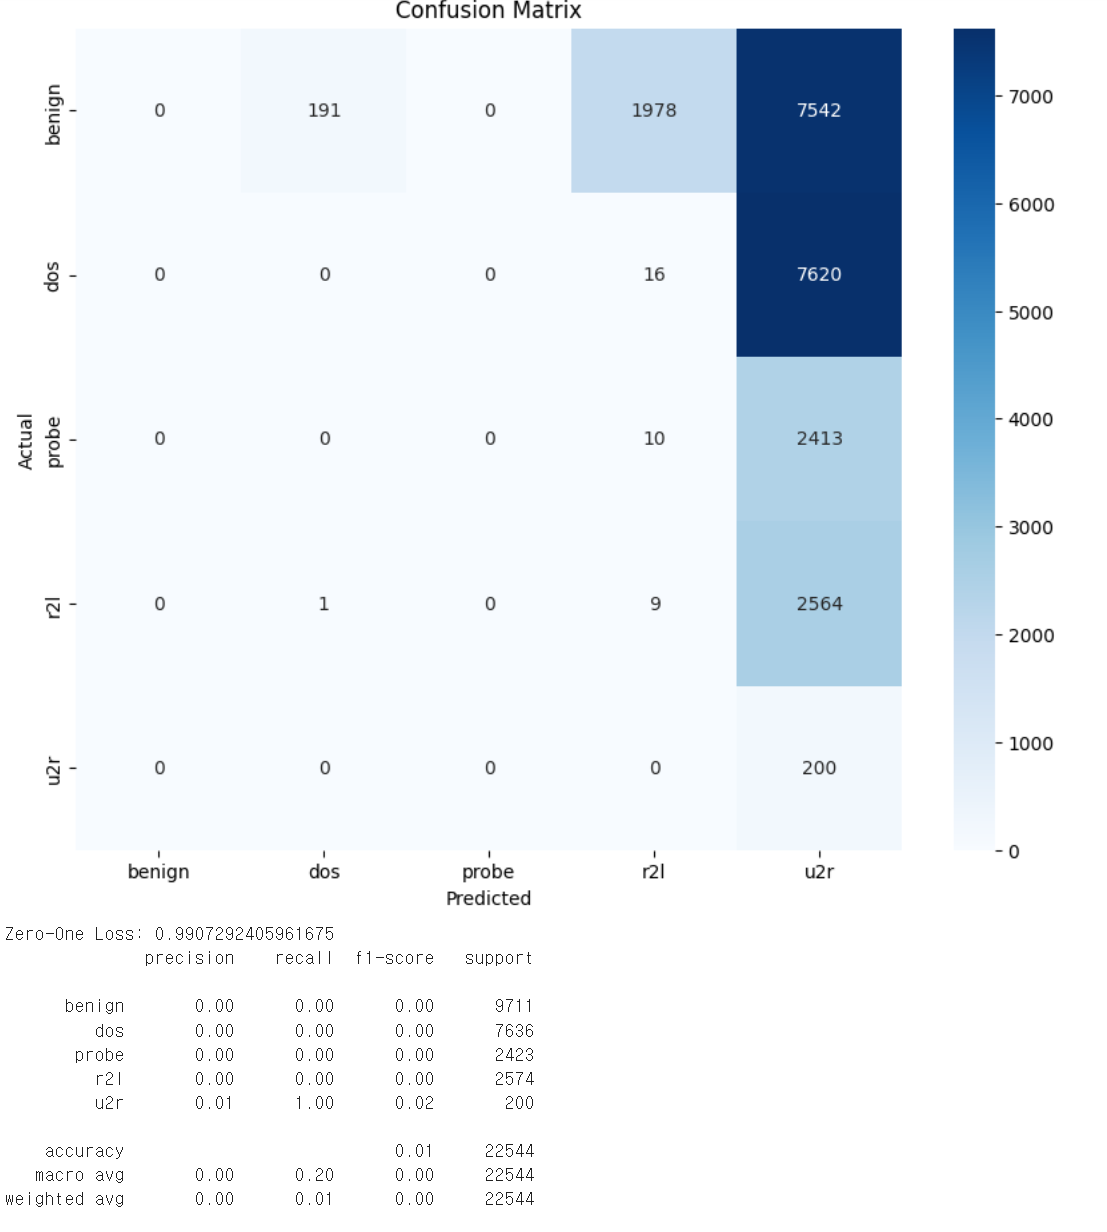

#     lambda_ = 0.0001 epochs = 5

Epoch 1/5
Training loss for episode: 1.0834944606497883
Training loss for episode: 0.5826400306560099
Training loss for episode: 0.47954637790843846
Training loss for episode: 0.4048787625275552
Training loss for episode: 0.3489969630470499
Training loss for episode: 0.312131360668689
Training loss for episode: 0.22957527436427771
Training loss for episode: 0.16607922740438952
Training loss for episode: 0.17541355379689486
Training loss for episode: 0.14582867660010235
Epoch 1/5, Average Loss: 0.3928584687623195
Epoch 2/5
Training loss for episode: 0.14778145954469218
Training loss for episode: 0.15454995602467098
Training loss for episode: 0.17774470955124125
Training loss for episode: 0.11145535767730326
Training loss for episode: 0.1406850306581706
Training loss for episode: 0.11847987464610488
Training loss for episode: 0.0909551137272385
Training loss for episode: 0.11104669593525468
Training loss for episode: 0.09780500566979172
Training loss for episode: 0.09909891327645164
Epoc

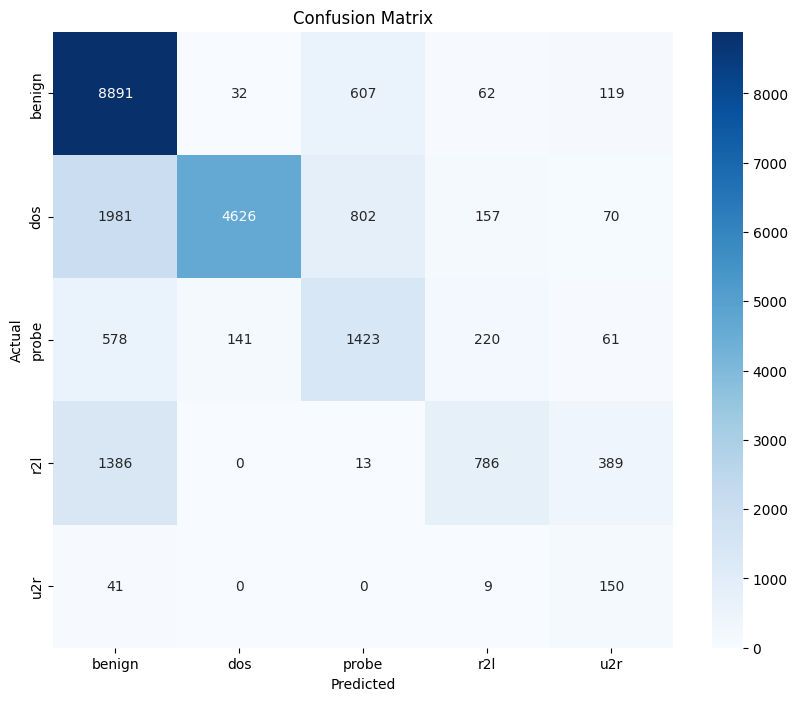

              precision    recall  f1-score   support

      benign       0.69      0.92      0.79      9711
         dos       0.96      0.61      0.74      7636
       probe       0.50      0.59      0.54      2423
         r2l       0.64      0.31      0.41      2574
         u2r       0.19      0.75      0.30       200

    accuracy                           0.70     22544
   macro avg       0.60      0.63      0.56     22544
weighted avg       0.75      0.70      0.70     22544

Zero-One Loss: 0.29577714691270407
Support Set:
tensor([[[[0.0000, 0.2733, 0.3618,  ..., 1.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.3522, 0.0000, 0.0000],
          [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.1819, 0.2087,  ..., 0.0000,

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Center Loss Definition
class CenterLoss(nn.Module):
    def __init__(self, num_classes=5, feat_dim=121, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        labels = labels.expand(batch_size, self.num_classes)

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu:
            classes = classes.cuda()
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# CNN Model Definition with Residual Blocks
class CNNModel(nn.Module):
    def __init__(self, input_shape, embedding_dim=121, num_classes=5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)

        # Adding Residual Blocks with reduced downsampling
        self.res_block1 = ResidualBlock(4, 16, stride=1)
        self.res_block2 = ResidualBlock(16, 64, stride=1)
        self.res_block3 = ResidualBlock(64, 121, stride=1)

        # Only one pooling layer after initial conv and res blocks
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output after the residual blocks
        self._to_linear = None
        self.convs(torch.randn(1, *input_shape))

        self.fc = nn.Linear(self._to_linear, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def convs(self, x):
        x = F.relu(self.conv1(x))           # Initial conv
        x = self.pool(x)                    # Pooling after initial conv
        x = self.res_block1(x)              # Residual block 1
        x = self.res_block2(x)              # Residual block 2
        x = self.res_block3(x)              # Residual block 3
        x = self.pool(x)                    # Pooling after res_block3

        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        embeddings = F.relu(self.fc(x))
        outputs = self.classifier(embeddings)
        return embeddings, outputs

# Custom collate function to move data to device
def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data).to(device)
    target = torch.tensor(target).to(device)
    return data, target

# Data Preparation
def prepare_data(device):
    # Assuming combined_df, train_df, and test_df are already defined
    # Example data preparation process
    train_x = combined_df[:len(train_x_raw)]
    test_x = combined_df[len(train_x_raw):]

    train_x.iloc[:, 37:118] = train_x.iloc[:, 37:118].astype(int)
    test_x.iloc[:, 37:118] = test_x.iloc[:, 37:118].astype(int)

    train_x = train_x.applymap(lambda x: np.log(x + 1))
    test_x = test_x.applymap(lambda x: np.log(x + 1))

    numeric_cols = train_x.columns[train_x.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
    min_max_scaler = MinMaxScaler().fit(train_x[numeric_cols])

    train_x[numeric_cols] = min_max_scaler.transform(train_x[numeric_cols])
    test_x[numeric_cols] = min_max_scaler.transform(test_x[numeric_cols])

    pad_width = 121 - 118
    train_x = np.pad(train_x.values, ((0, 0), (0, pad_width)), mode='constant')
    test_x = np.pad(test_x.values, ((0, 0), (0, pad_width)), mode='constant')

    train_x = torch.tensor(train_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)
    test_x = torch.tensor(test_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)

    train_Y = train_df['attack_category']
    test_Y = test_df['attack_category']
    label_encoder = LabelEncoder()
    train_Y_int = label_encoder.fit_transform(train_Y)
    test_Y_int = label_encoder.transform(test_Y)

    train_Y = torch.tensor(train_Y_int, dtype=torch.long).to(device)
    test_Y = torch.tensor(test_Y_int, dtype=torch.long).to(device)

    train_dataset = TensorDataset(train_x, train_Y)
    test_dataset = TensorDataset(test_x, test_Y)
    return train_dataset, test_dataset, label_encoder

# Training Episode Function
def training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device):
    model.train()
    J = 0  # Initialize total loss
    episode_loss = 0  # Initialize loss for this episode
    count = 0  # Counter for number of iterations

    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    for class_label in range(num_classes):
        # Step 3: Select training examples from the training dataset
        Q_k = []
        Q_y = []
        for j in range(num_classes):
            train_indices = torch.where(train_loader.dataset.tensors[1] == j)[0]
            sampled_indices = train_indices[torch.randperm(len(train_indices))[:N_T]]
            Q_k.append(train_loader.dataset.tensors[0][sampled_indices])
            Q_y.append(train_loader.dataset.tensors[1][sampled_indices])
        Q_k = torch.cat(Q_k).to(device)
        Q_y = torch.cat(Q_y).to(device)

        # Compute the benchmark of embedding features
        with torch.no_grad():
            S_k_embeddings, _ = model(support_x)
        c_k = S_k_embeddings.mean(dim=0)

        for x, y in zip(Q_k, Q_y):
            x = x.unsqueeze(0)  # Reshape to match model input shape
            optimizer.zero_grad()
            embeddings, outputs = model(x)
            L_S = criterion(outputs, y.unsqueeze(0))
            L_C = center_loss_func(embeddings, y)
            loss = L_S + lambda_ * L_C
            loss.backward()
            optimizer.step()
            #J += (1 / (num_classes * len(train_loader) * len(Q_k))) * loss.item()
            episode_loss += loss.item()
            count += 1

    # Compute average loss for this episode
    average_loss = episode_loss / count
    print(f"Training loss for episode: {average_loss}")

    return average_loss

# Training Loop
def train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        final_loss = 0

        for _ in range(N_P):
            # Create support set from training data
            support_indices = []
            for class_label in range(num_classes):
                class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
                support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

            support_set = Subset(train_loader.dataset, support_indices)

            # Train for one episode
            episode_loss2 = training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device)
            final_loss += episode_loss2

        final_loss /= N_P
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {final_loss}')


# Testing Phase Function
def test_phase(test_loader, support_set, model, device, label_encoder, batch_size=32, chunk_size=100):
    model.eval()
    test_x, test_Y = test_loader.dataset.tensors
    support_x, support_Y = support_set.tensors

    with torch.no_grad():
        # Compute embeddings for the support set
        support_embeddings, _ = model(support_x.to(device))

        # Compute embeddings for the test set in batches
        test_embeddings = []
        for i in range(0, len(test_x), batch_size):
            batch_x = test_x[i:i + batch_size].to(device)
            batch_embeddings, _ = model(batch_x)
            test_embeddings.append(batch_embeddings.cpu())

        test_embeddings = torch.cat(test_embeddings).to(device)

        # Compute similarities in chunks to avoid memory overflow
        similarities = []
        for i in range(0, len(test_embeddings), chunk_size):
            chunk_test_embeddings = test_embeddings[i:i + chunk_size]
            chunk_similarities = F.cosine_similarity(chunk_test_embeddings.unsqueeze(1), support_embeddings.unsqueeze(0), dim=-1)
            similarities.append(chunk_similarities.cpu())

        similarities = torch.cat(similarities).to(device)
        from sklearn.metrics import confusion_matrix, classification_report
        from sklearn.metrics import confusion_matrix, zero_one_loss

        # Get the predicted labels based on maximum similarity
        predicted_indices = similarities.argmax(dim=1)
        predicted_indices = predicted_indices.to(support_Y.device)
        predicted_labels = support_Y[predicted_indices].cpu().numpy()

        # Evaluate with confusion matrix
        conf_matrix = confusion_matrix(test_Y.cpu().numpy(), predicted_labels)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_.tolist(), yticklabels=label_encoder.classes_.tolist())
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # Print classification report
        print(classification_report(test_Y.cpu().numpy(), predicted_labels, target_names=label_encoder.classes_))

        # Print zero-one loss
        error = zero_one_loss(test_Y.cpu().numpy(), predicted_labels)
        print("Zero-One Loss:", error)

# Main Function
if __name__ == "__main__":
    # Hyperparameters
    N_T = 50  # Number of training samples per class
    N_S = 10  # Number of support samples per class
    lambda_ = 0.0001
    epochs = 5
    batch_size = 32
    num_classes = 5
    input_shape = (1, 11, 11)
    embedding_dim = 121
    N_P = 10  # Number of sampling episodes

    # Prepare data
    train_dataset, test_dataset, label_encoder = prepare_data(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize model, loss functions, and optimizer
    model = CNNModel(input_shape, embedding_dim, num_classes).to(device)
    center_loss_func = CenterLoss(num_classes=num_classes, feat_dim=embedding_dim, use_gpu=torch.cuda.is_available())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(model.parameters()) + list(center_loss_func.parameters()), lr=0.001)

    # Train the model
    train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device)

    # Create support set from training data for testing phase
    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    # Evaluate the model in the testing phase
    test_phase(test_loader, support_set, model, device, label_encoder)


#     lambda_ = 0.0001    epochs = 4

Epoch 1/4
Training loss: 1.0438436188831925
Epoch 1/4, Loss: 0.00026513680946995023
Epoch 2/4
Training loss: 0.6810012833617628
Epoch 2/4, Loss: 0.00017297467192323144
Epoch 3/4
Training loss: 0.5674063437156379
Epoch 3/4, Loss: 0.00014412149954677158
Epoch 4/4
Training loss: 0.3959493077144027
Epoch 4/4, Loss: 0.0001005713253021089


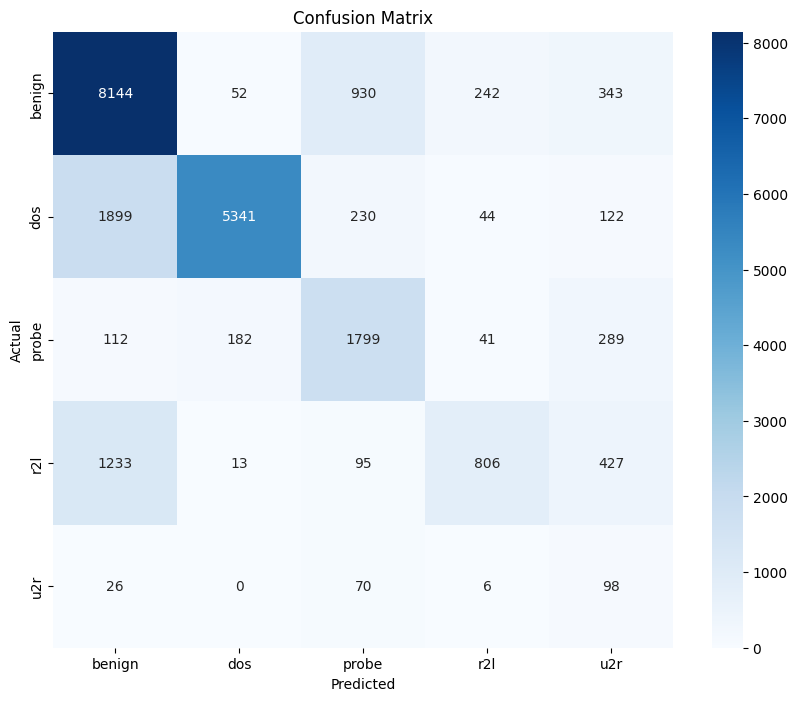

              precision    recall  f1-score   support

      benign       0.71      0.84      0.77      9711
         dos       0.96      0.70      0.81      7636
       probe       0.58      0.74      0.65      2423
         r2l       0.71      0.31      0.43      2574
         u2r       0.08      0.49      0.13       200

    accuracy                           0.72     22544
   macro avg       0.61      0.62      0.56     22544
weighted avg       0.77      0.72      0.73     22544

Zero-One Loss: 0.28193754435770046
Support Set:
tensor([[[[0.0000, 0.2618, 0.4007,  ..., 1.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1111, 0.0000, 0.0000],
          [0.0000, 0.0000, 1.0000,  ..., 0.0144, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.1632, 0.0000,  ..., 0.0000,

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Center Loss Definition
class CenterLoss(nn.Module):
    def __init__(self, num_classes=5, feat_dim=121, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        labels = labels.expand(batch_size, self.num_classes)

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu:
            classes = classes.cuda()
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# CNN Model Definition with Residual Blocks
class CNNModel(nn.Module):
    def __init__(self, input_shape, embedding_dim=121, num_classes=5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)

        # Adding Residual Blocks with reduced downsampling
        self.res_block1 = ResidualBlock(4, 16, stride=1)
        self.res_block2 = ResidualBlock(16, 64, stride=1)
        self.res_block3 = ResidualBlock(64, 121, stride=1)

        # Only one pooling layer after initial conv and res blocks
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output after the residual blocks
        self._to_linear = None
        self.convs(torch.randn(1, *input_shape))

        self.fc = nn.Linear(self._to_linear, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def convs(self, x):
        x = F.relu(self.conv1(x))           # Initial conv
        x = self.pool(x)                    # Pooling after initial conv
        x = self.res_block1(x)              # Residual block 1
        x = self.res_block2(x)              # Residual block 2
        x = self.res_block3(x)              # Residual block 3
        x = self.pool(x)                    # Pooling after res_block3

        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        embeddings = F.relu(self.fc(x))
        outputs = self.classifier(embeddings)
        return embeddings, outputs

# Custom collate function to move data to device
def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data).to(device)
    target = torch.tensor(target).to(device)
    return data, target

# Data Preparation
def prepare_data(device):
    # Assuming combined_df, train_df, and test_df are already defined
    # Example data preparation process
    train_x = combined_df[:len(train_x_raw)]
    test_x = combined_df[len(train_x_raw):]

    train_x.iloc[:, 37:118] = train_x.iloc[:, 37:118].astype(int)
    test_x.iloc[:, 37:118] = test_x.iloc[:, 37:118].astype(int)

    train_x = train_x.applymap(lambda x: np.log(x + 1))
    test_x = test_x.applymap(lambda x: np.log(x + 1))

    numeric_cols = train_x.columns[train_x.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
    min_max_scaler = MinMaxScaler().fit(train_x[numeric_cols])

    train_x[numeric_cols] = min_max_scaler.transform(train_x[numeric_cols])
    test_x[numeric_cols] = min_max_scaler.transform(test_x[numeric_cols])

    pad_width = 121 - 118
    train_x = np.pad(train_x.values, ((0, 0), (0, pad_width)), mode='constant')
    test_x = np.pad(test_x.values, ((0, 0), (0, pad_width)), mode='constant')

    train_x = torch.tensor(train_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)
    test_x = torch.tensor(test_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)

    train_Y = train_df['attack_category']
    test_Y = test_df['attack_category']
    label_encoder = LabelEncoder()
    train_Y_int = label_encoder.fit_transform(train_Y)
    test_Y_int = label_encoder.transform(test_Y)

    train_Y = torch.tensor(train_Y_int, dtype=torch.long).to(device)
    test_Y = torch.tensor(test_Y_int, dtype=torch.long).to(device)

    train_dataset = TensorDataset(train_x, train_Y)
    test_dataset = TensorDataset(test_x, test_Y)
    return train_dataset, test_dataset, label_encoder

# Training Episode Function
def training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device):
    model.train()
    J = 0  # Initialize total loss
    episode_loss = 0  # Initialize loss for this episode
    count = 0  # Counter for number of iterations

    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    for class_label in range(num_classes):
        # Step 3: Select training examples from the training dataset
        Q_k = []
        Q_y = []
        for j in range(num_classes):
            train_indices = torch.where(train_loader.dataset.tensors[1] == j)[0]
            sampled_indices = train_indices[torch.randperm(len(train_indices))[:N_T]]
            Q_k.append(train_loader.dataset.tensors[0][sampled_indices])
            Q_y.append(train_loader.dataset.tensors[1][sampled_indices])
        Q_k = torch.cat(Q_k).to(device)
        Q_y = torch.cat(Q_y).to(device)

        # Compute the benchmark of embedding features
        with torch.no_grad():
            S_k_embeddings, _ = model(support_x)
        c_k = S_k_embeddings.mean(dim=0)

        for x, y in zip(Q_k, Q_y):
            x = x.unsqueeze(0)  # Reshape to match model input shape
            optimizer.zero_grad()
            embeddings, outputs = model(x)
            L_S = criterion(outputs, y.unsqueeze(0))
            L_C = center_loss_func(embeddings, y)
            loss = L_S + lambda_ * L_C
            loss.backward()
            optimizer.step()
            J += (1 / (num_classes * len(train_loader) * len(Q_k))) * loss.item()
            episode_loss += loss.item()
            count += 1

    # Compute average loss for this episode
    average_loss = episode_loss / count
    print(f"Training loss: {average_loss}")

    return J

# Training Loop
def train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, device):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Create support set from training data
        support_indices = []
        for class_label in range(num_classes):
            class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
            support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

        support_set = Subset(train_loader.dataset, support_indices)

        # Train for one epoch
        final_loss = training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {final_loss}')

# Testing Phase Function
def test_phase(test_loader, support_set, model, device, label_encoder, batch_size=32, chunk_size=100):
    model.eval()
    test_x, test_Y = test_loader.dataset.tensors
    support_x, support_Y = support_set.tensors

    with torch.no_grad():
        # Compute embeddings for the support set
        support_embeddings, _ = model(support_x.to(device))

        # Compute embeddings for the test set in batches
        test_embeddings = []
        for i in range(0, len(test_x), batch_size):
            batch_x = test_x[i:i + batch_size].to(device)
            batch_embeddings, _ = model(batch_x)
            test_embeddings.append(batch_embeddings.cpu())

        test_embeddings = torch.cat(test_embeddings).to(device)

        # Compute similarities in chunks to avoid memory overflow
        similarities = []
        for i in range(0, len(test_embeddings), chunk_size):
            chunk_test_embeddings = test_embeddings[i:i + chunk_size]
            chunk_similarities = F.cosine_similarity(chunk_test_embeddings.unsqueeze(1), support_embeddings.unsqueeze(0), dim=-1)
            similarities.append(chunk_similarities.cpu())

        similarities = torch.cat(similarities).to(device)

        # Get the predicted labels based on maximum similarity
        predicted_indices = similarities.argmax(dim=1)
        predicted_indices = predicted_indices.to(support_Y.device)
        predicted_labels = support_Y[predicted_indices].cpu().numpy()

        from sklearn.metrics import confusion_matrix, classification_report
        from sklearn.metrics import confusion_matrix, zero_one_loss
        # Evaluate with confusion matrix
        conf_matrix = confusion_matrix(test_Y.cpu().numpy(), predicted_labels)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_.tolist(), yticklabels=label_encoder.classes_.tolist())
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # Print classification report
        print(classification_report(test_Y.cpu().numpy(), predicted_labels, target_names=label_encoder.classes_))

        # Print zero-one loss
        error = zero_one_loss(test_Y.cpu().numpy(), predicted_labels)
        print("Zero-One Loss:", error)

    # Print the support set for verification
    print("Support Set:")
    print(support_x)
    print(support_Y)

# Main Function
if __name__ == "__main__":
    # Hyperparameters
    N_T = 50  # Number of training samples per class
    N_S = 10  # Number of support samples per class
    lambda_ = 0.0001
    epochs = 4
    batch_size = 32
    num_classes = 5
    input_shape = (1, 11, 11)
    embedding_dim = 121

    # Prepare data
    train_dataset, test_dataset, label_encoder = prepare_data(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize model, loss functions, and optimizer
    model = CNNModel(input_shape, embedding_dim, num_classes).to(device)
    center_loss_func = CenterLoss(num_classes=num_classes, feat_dim=embedding_dim, use_gpu=torch.cuda.is_available())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(model.parameters()) + list(center_loss_func.parameters()), lr=0.001)

    # Train the model
    train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, device)

    # Create support set from training data for testing phase
    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    # Evaluate the model in the testing phase
    test_phase(test_loader, support_set, model, device, label_encoder)


#     lambda_ = 0.00005    epochs = 5

Epoch 1/5
Training loss for episode: 1.056143999568373
Training loss for episode: 0.8133343956142663
Training loss for episode: 0.7809798430301249
Training loss for episode: 0.7030591625485569
Training loss for episode: 0.6134074320500716
Training loss for episode: 0.41991610828693954
Training loss for episode: 0.3442955598866567
Training loss for episode: 0.29612108762525025
Training loss for episode: 0.2269027525559999
Training loss for episode: 0.18106737324642017
Epoch 1/5, Average Loss: 0.543522771441266
Epoch 2/5
Training loss for episode: 0.17497847608299927
Training loss for episode: 0.181348042003531
Training loss for episode: 0.1654847254343331
Training loss for episode: 0.17204134073259775
Training loss for episode: 0.14577735521362628
Training loss for episode: 0.13297103941193783
Training loss for episode: 0.1599388714695582
Training loss for episode: 0.10879807221612427
Training loss for episode: 0.14212169424616733
Training loss for episode: 0.18071020087504294
Epoch 2/5

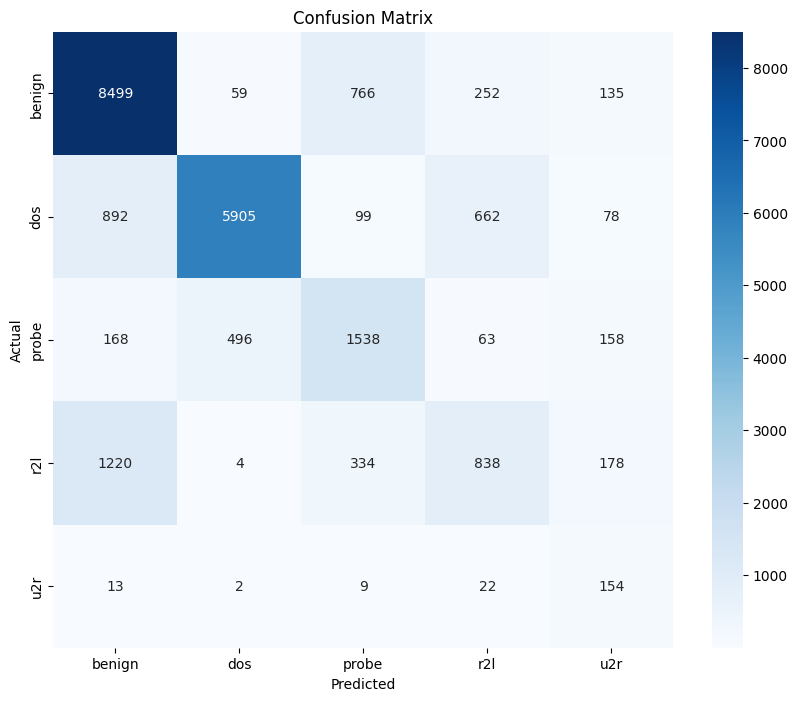

              precision    recall  f1-score   support

      benign       0.79      0.88      0.83      9711
         dos       0.91      0.77      0.84      7636
       probe       0.56      0.63      0.60      2423
         r2l       0.46      0.33      0.38      2574
         u2r       0.22      0.77      0.34       200

    accuracy                           0.75     22544
   macro avg       0.59      0.68      0.60     22544
weighted avg       0.76      0.75      0.75     22544

Zero-One Loss: 0.24884669978708307


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Center Loss Definition
class CenterLoss(nn.Module):
    def __init__(self, num_classes=5, feat_dim=121, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        labels = labels.expand(batch_size, self.num_classes)

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu:
            classes = classes.cuda()
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# CNN Model Definition with Residual Blocks
class CNNModel(nn.Module):
    def __init__(self, input_shape, embedding_dim=121, num_classes=5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)

        # Adding Residual Blocks with reduced downsampling
        self.res_block1 = ResidualBlock(4, 16, stride=1)
        self.res_block2 = ResidualBlock(16, 64, stride=1)
        self.res_block3 = ResidualBlock(64, 121, stride=1)

        # Only one pooling layer after initial conv and res blocks
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output after the residual blocks
        self._to_linear = None
        self.convs(torch.randn(1, *input_shape))

        self.fc = nn.Linear(self._to_linear, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def convs(self, x):
        x = F.relu(self.conv1(x))           # Initial conv
        x = self.pool(x)                    # Pooling after initial conv
        x = self.res_block1(x)              # Residual block 1
        x = self.res_block2(x)              # Residual block 2
        x = self.res_block3(x)              # Residual block 3
        x = self.pool(x)                    # Pooling after res_block3

        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        embeddings = F.relu(self.fc(x))
        outputs = self.classifier(embeddings)
        return embeddings, outputs

# Custom collate function to move data to device
def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data).to(device)
    target = torch.tensor(target).to(device)
    return data, target

# Data Preparation
def prepare_data(device):
    # Assuming combined_df, train_df, and test_df are already defined
    # Example data preparation process
    train_x = combined_df[:len(train_x_raw)]
    test_x = combined_df[len(train_x_raw):]

    train_x.iloc[:, 37:118] = train_x.iloc[:, 37:118].astype(int)
    test_x.iloc[:, 37:118] = test_x.iloc[:, 37:118].astype(int)

    train_x = train_x.applymap(lambda x: np.log(x + 1))
    test_x = test_x.applymap(lambda x: np.log(x + 1))

    numeric_cols = train_x.columns[train_x.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
    min_max_scaler = MinMaxScaler().fit(train_x[numeric_cols])

    train_x[numeric_cols] = min_max_scaler.transform(train_x[numeric_cols])
    test_x[numeric_cols] = min_max_scaler.transform(test_x[numeric_cols])

    pad_width = 121 - 118
    train_x = np.pad(train_x.values, ((0, 0), (0, pad_width)), mode='constant')
    test_x = np.pad(test_x.values, ((0, 0), (0, pad_width)), mode='constant')

    train_x = torch.tensor(train_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)
    test_x = torch.tensor(test_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)

    train_Y = train_df['attack_category']
    test_Y = test_df['attack_category']
    label_encoder = LabelEncoder()
    train_Y_int = label_encoder.fit_transform(train_Y)
    test_Y_int = label_encoder.transform(test_Y)

    train_Y = torch.tensor(train_Y_int, dtype=torch.long).to(device)
    test_Y = torch.tensor(test_Y_int, dtype=torch.long).to(device)

    train_dataset = TensorDataset(train_x, train_Y)
    test_dataset = TensorDataset(test_x, test_Y)
    return train_dataset, test_dataset, label_encoder

# Training Episode Function
def training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device):
    model.train()
    J = 0  # Initialize total loss
    episode_loss = 0  # Initialize loss for this episode
    count = 0  # Counter for number of iterations

    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    for class_label in range(num_classes):
        # Step 3: Select training examples from the training dataset
        Q_k = []
        Q_y = []
        for j in range(num_classes):
            train_indices = torch.where(train_loader.dataset.tensors[1] == j)[0]
            sampled_indices = train_indices[torch.randperm(len(train_indices))[:N_T]]
            Q_k.append(train_loader.dataset.tensors[0][sampled_indices])
            Q_y.append(train_loader.dataset.tensors[1][sampled_indices])
        Q_k = torch.cat(Q_k).to(device)
        Q_y = torch.cat(Q_y).to(device)

        # Compute the benchmark of embedding features
        with torch.no_grad():
            S_k_embeddings, _ = model(support_x)
        c_k = S_k_embeddings.mean(dim=0)

        for x, y in zip(Q_k, Q_y):
            x = x.unsqueeze(0)  # Reshape to match model input shape
            optimizer.zero_grad()
            embeddings, outputs = model(x)
            L_S = criterion(outputs, y.unsqueeze(0))
            L_C = center_loss_func(embeddings, y)
            loss = L_S + lambda_ * L_C
            loss.backward()
            optimizer.step()
            #J += (1 / (num_classes * len(train_loader) * len(Q_k))) * loss.item()
            episode_loss += loss.item()
            count += 1

    # Compute average loss for this episode
    average_loss = episode_loss / count
    print(f"Training loss for episode: {average_loss}")

    return average_loss

# Training Loop
def train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        final_loss = 0

        for _ in range(N_P):
            # Create support set from training data
            support_indices = []
            for class_label in range(num_classes):
                class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
                support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

            support_set = Subset(train_loader.dataset, support_indices)

            # Train for one episode
            episode_loss2 = training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device)
            final_loss += episode_loss2

        final_loss /= N_P
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {final_loss}')


# Testing Phase Function
def test_phase(test_loader, support_set, model, device, label_encoder, batch_size=32, chunk_size=100):
    model.eval()
    test_x, test_Y = test_loader.dataset.tensors
    support_x, support_Y = support_set.tensors

    with torch.no_grad():
        # Compute embeddings for the support set
        support_embeddings, _ = model(support_x.to(device))

        # Compute embeddings for the test set in batches
        test_embeddings = []
        for i in range(0, len(test_x), batch_size):
            batch_x = test_x[i:i + batch_size].to(device)
            batch_embeddings, _ = model(batch_x)
            test_embeddings.append(batch_embeddings.cpu())

        test_embeddings = torch.cat(test_embeddings).to(device)

        # Compute similarities in chunks to avoid memory overflow
        similarities = []
        for i in range(0, len(test_embeddings), chunk_size):
            chunk_test_embeddings = test_embeddings[i:i + chunk_size]
            chunk_similarities = F.cosine_similarity(chunk_test_embeddings.unsqueeze(1), support_embeddings.unsqueeze(0), dim=-1)
            similarities.append(chunk_similarities.cpu())

        similarities = torch.cat(similarities).to(device)
        from sklearn.metrics import confusion_matrix, classification_report
        from sklearn.metrics import confusion_matrix, zero_one_loss

        # Get the predicted labels based on maximum similarity
        predicted_indices = similarities.argmax(dim=1)
        predicted_indices = predicted_indices.to(support_Y.device)
        predicted_labels = support_Y[predicted_indices].cpu().numpy()

        # Evaluate with confusion matrix
        conf_matrix = confusion_matrix(test_Y.cpu().numpy(), predicted_labels)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_.tolist(), yticklabels=label_encoder.classes_.tolist())
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # Print classification report
        print(classification_report(test_Y.cpu().numpy(), predicted_labels, target_names=label_encoder.classes_))

        # Print zero-one loss
        error = zero_one_loss(test_Y.cpu().numpy(), predicted_labels)
        print("Zero-One Loss:", error)

# Main Function
if __name__ == "__main__":
    # Hyperparameters
    N_T = 50  # Number of training samples per class
    N_S = 10  # Number of support samples per class
    lambda_ = 0.00005
    epochs = 5
    batch_size = 32
    num_classes = 5
    input_shape = (1, 11, 11)
    embedding_dim = 121
    N_P = 10  # Number of sampling episodes

    # Prepare data
    train_dataset, test_dataset, label_encoder = prepare_data(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize model, loss functions, and optimizer
    model = CNNModel(input_shape, embedding_dim, num_classes).to(device)
    center_loss_func = CenterLoss(num_classes=num_classes, feat_dim=embedding_dim, use_gpu=torch.cuda.is_available())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(model.parameters()) + list(center_loss_func.parameters()), lr=0.001)

    # Train the model
    train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device)

    # Create support set from training data for testing phase
    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    # Evaluate the model in the testing phase
    test_phase(test_loader, support_set, model, device, label_encoder)


#     lambda_ = 0.00001    epochs = 10


Epoch 1/10
Training loss for episode: 1.016858851169795
Training loss for episode: 0.9248282560298219
Training loss for episode: 0.7510349396048114
Training loss for episode: 0.6841874698187225
Training loss for episode: 0.561815650373511
Training loss for episode: 0.4190674071311485
Training loss for episode: 0.2982837586528854
Training loss for episode: 0.2813098524929257
Training loss for episode: 0.25204428349733354
Training loss for episode: 0.24473057438179385
Epoch 1/10, Average Loss: 0.5434161043152749
Epoch 2/10
Training loss for episode: 0.21633101179833758
Training loss for episode: 0.21685951441598592
Training loss for episode: 0.16232148984549566
Training loss for episode: 0.15840522395973095
Training loss for episode: 0.15894129686261876
Training loss for episode: 0.1690373266823066
Training loss for episode: 0.15277572695648414
Training loss for episode: 0.13888417509482825
Training loss for episode: 0.11812107745481189
Training loss for episode: 0.12788764320623594
Epoc

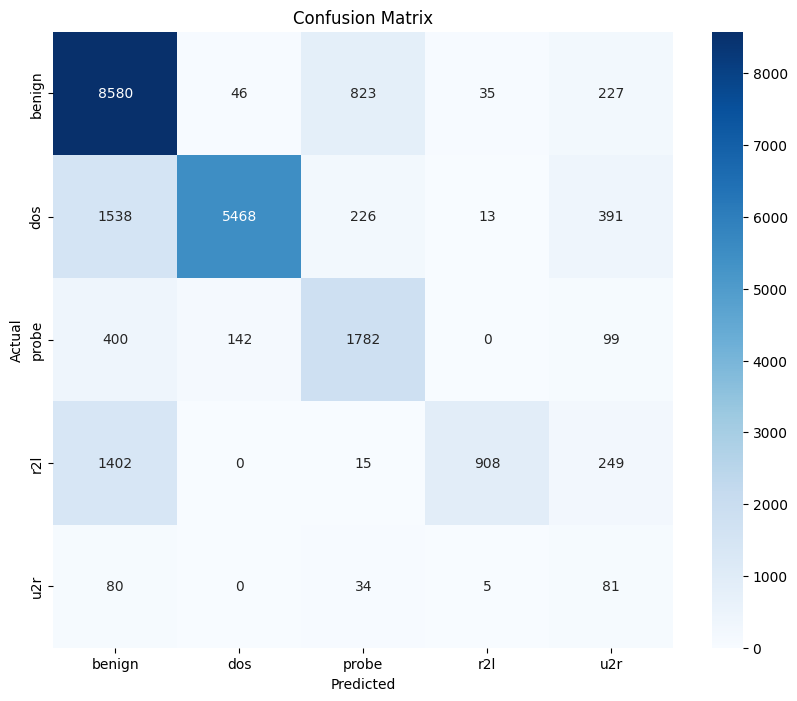

              precision    recall  f1-score   support

      benign       0.71      0.88      0.79      9711
         dos       0.97      0.72      0.82      7636
       probe       0.62      0.74      0.67      2423
         r2l       0.94      0.35      0.51      2574
         u2r       0.08      0.41      0.13       200

    accuracy                           0.75     22544
   macro avg       0.66      0.62      0.59     22544
weighted avg       0.81      0.75      0.75     22544

Zero-One Loss: 0.2539478353442157


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Center Loss Definition
class CenterLoss(nn.Module):
    def __init__(self, num_classes=5, feat_dim=121, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        labels = labels.expand(batch_size, self.num_classes)

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu:
            classes = classes.cuda()
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# CNN Model Definition with Residual Blocks
class CNNModel(nn.Module):
    def __init__(self, input_shape, embedding_dim=121, num_classes=5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)

        # Adding Residual Blocks with reduced downsampling
        self.res_block1 = ResidualBlock(4, 16, stride=1)
        self.res_block2 = ResidualBlock(16, 64, stride=1)
        self.res_block3 = ResidualBlock(64, 121, stride=1)

        # Only one pooling layer after initial conv and res blocks
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output after the residual blocks
        self._to_linear = None
        self.convs(torch.randn(1, *input_shape))

        self.fc = nn.Linear(self._to_linear, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def convs(self, x):
        x = F.relu(self.conv1(x))           # Initial conv
        x = self.pool(x)                    # Pooling after initial conv
        x = self.res_block1(x)              # Residual block 1
        x = self.res_block2(x)              # Residual block 2
        x = self.res_block3(x)              # Residual block 3
        x = self.pool(x)                    # Pooling after res_block3

        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        embeddings = F.relu(self.fc(x))
        outputs = self.classifier(embeddings)
        return embeddings, outputs

# Custom collate function to move data to device
def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data).to(device)
    target = torch.tensor(target).to(device)
    return data, target

# Data Preparation
def prepare_data(device):
    # Assuming combined_df, train_df, and test_df are already defined
    # Example data preparation process
    train_x = combined_df[:len(train_x_raw)]
    test_x = combined_df[len(train_x_raw):]

    train_x.iloc[:, 37:118] = train_x.iloc[:, 37:118].astype(int)
    test_x.iloc[:, 37:118] = test_x.iloc[:, 37:118].astype(int)

    train_x = train_x.applymap(lambda x: np.log(x + 1))
    test_x = test_x.applymap(lambda x: np.log(x + 1))

    numeric_cols = train_x.columns[train_x.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
    min_max_scaler = MinMaxScaler().fit(train_x[numeric_cols])

    train_x[numeric_cols] = min_max_scaler.transform(train_x[numeric_cols])
    test_x[numeric_cols] = min_max_scaler.transform(test_x[numeric_cols])

    pad_width = 121 - 118
    train_x = np.pad(train_x.values, ((0, 0), (0, pad_width)), mode='constant')
    test_x = np.pad(test_x.values, ((0, 0), (0, pad_width)), mode='constant')

    train_x = torch.tensor(train_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)
    test_x = torch.tensor(test_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)

    train_Y = train_df['attack_category']
    test_Y = test_df['attack_category']
    label_encoder = LabelEncoder()
    train_Y_int = label_encoder.fit_transform(train_Y)
    test_Y_int = label_encoder.transform(test_Y)

    train_Y = torch.tensor(train_Y_int, dtype=torch.long).to(device)
    test_Y = torch.tensor(test_Y_int, dtype=torch.long).to(device)

    train_dataset = TensorDataset(train_x, train_Y)
    test_dataset = TensorDataset(test_x, test_Y)
    return train_dataset, test_dataset, label_encoder

# Training Episode Function
def training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device):
    model.train()
    J = 0  # Initialize total loss
    episode_loss = 0  # Initialize loss for this episode
    count = 0  # Counter for number of iterations

    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    for class_label in range(num_classes):
        # Step 3: Select training examples from the training dataset
        Q_k = []
        Q_y = []
        for j in range(num_classes):
            train_indices = torch.where(train_loader.dataset.tensors[1] == j)[0]
            sampled_indices = train_indices[torch.randperm(len(train_indices))[:N_T]]
            Q_k.append(train_loader.dataset.tensors[0][sampled_indices])
            Q_y.append(train_loader.dataset.tensors[1][sampled_indices])
        Q_k = torch.cat(Q_k).to(device)
        Q_y = torch.cat(Q_y).to(device)

        # Compute the benchmark of embedding features
        with torch.no_grad():
            S_k_embeddings, _ = model(support_x)
        c_k = S_k_embeddings.mean(dim=0)

        for x, y in zip(Q_k, Q_y):
            x = x.unsqueeze(0)  # Reshape to match model input shape
            optimizer.zero_grad()
            embeddings, outputs = model(x)
            L_S = criterion(outputs, y.unsqueeze(0))
            L_C = center_loss_func(embeddings, y)
            loss = L_S + lambda_ * L_C
            loss.backward()
            optimizer.step()
            #J += (1 / (num_classes * len(train_loader) * len(Q_k))) * loss.item()
            episode_loss += loss.item()
            count += 1

    # Compute average loss for this episode
    average_loss = episode_loss / count
    print(f"Training loss for episode: {average_loss}")

    return average_loss

# Training Loop
def train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        final_loss = 0

        for _ in range(N_P):
            # Create support set from training data
            support_indices = []
            for class_label in range(num_classes):
                class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
                support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

            support_set = Subset(train_loader.dataset, support_indices)

            # Train for one episode
            episode_loss2 = training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device)
            final_loss += episode_loss2

        final_loss /= N_P
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {final_loss}')


# Testing Phase Function
def test_phase(test_loader, support_set, model, device, label_encoder, batch_size=32, chunk_size=100):
    model.eval()
    test_x, test_Y = test_loader.dataset.tensors
    support_x, support_Y = support_set.tensors

    with torch.no_grad():
        # Compute embeddings for the support set
        support_embeddings, _ = model(support_x.to(device))

        # Compute embeddings for the test set in batches
        test_embeddings = []
        for i in range(0, len(test_x), batch_size):
            batch_x = test_x[i:i + batch_size].to(device)
            batch_embeddings, _ = model(batch_x)
            test_embeddings.append(batch_embeddings.cpu())

        test_embeddings = torch.cat(test_embeddings).to(device)

        # Compute similarities in chunks to avoid memory overflow
        similarities = []
        for i in range(0, len(test_embeddings), chunk_size):
            chunk_test_embeddings = test_embeddings[i:i + chunk_size]
            chunk_similarities = F.cosine_similarity(chunk_test_embeddings.unsqueeze(1), support_embeddings.unsqueeze(0), dim=-1)
            similarities.append(chunk_similarities.cpu())

        similarities = torch.cat(similarities).to(device)
        from sklearn.metrics import confusion_matrix, classification_report
        from sklearn.metrics import confusion_matrix, zero_one_loss

        # Get the predicted labels based on maximum similarity
        predicted_indices = similarities.argmax(dim=1)
        predicted_indices = predicted_indices.to(support_Y.device)
        predicted_labels = support_Y[predicted_indices].cpu().numpy()

        # Evaluate with confusion matrix
        conf_matrix = confusion_matrix(test_Y.cpu().numpy(), predicted_labels)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_.tolist(), yticklabels=label_encoder.classes_.tolist())
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # Print classification report
        print(classification_report(test_Y.cpu().numpy(), predicted_labels, target_names=label_encoder.classes_))

        # Print zero-one loss
        error = zero_one_loss(test_Y.cpu().numpy(), predicted_labels)
        print("Zero-One Loss:", error)

# Main Function
if __name__ == "__main__":
    # Hyperparameters
    N_T = 50  # Number of training samples per class
    N_S = 10  # Number of support samples per class
    lambda_ = 0.00001
    epochs = 10
    batch_size = 32
    num_classes = 5
    input_shape = (1, 11, 11)
    embedding_dim = 121
    N_P = 10  # Number of sampling episodes

    # Prepare data
    train_dataset, test_dataset, label_encoder = prepare_data(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize model, loss functions, and optimizer
    model = CNNModel(input_shape, embedding_dim, num_classes).to(device)
    center_loss_func = CenterLoss(num_classes=num_classes, feat_dim=embedding_dim, use_gpu=torch.cuda.is_available())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(model.parameters()) + list(center_loss_func.parameters()), lr=0.001)

    # Train the model
    train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device)

    # Create support set from training data for testing phase
    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    # Evaluate the model in the testing phase
    test_phase(test_loader, support_set, model, device, label_encoder)


# lambda_=0 epochs=5

Epoch 1/5
Training loss for episode: 1.0234399395206324
Training loss for episode: 0.7064268808884104
Training loss for episode: 0.5771985843419613
Training loss for episode: 0.4402565651359786
Training loss for episode: 0.4186810168110489
Training loss for episode: 0.307192769804166
Training loss for episode: 0.3594924567801788
Training loss for episode: 0.30811931913362467
Training loss for episode: 0.23890977963731558
Training loss for episode: 0.26470391072229166
Epoch 1/5, Average Loss: 0.4644421222775607
Epoch 2/5
Training loss for episode: 0.2359692268859343
Training loss for episode: 0.195116496456582
Training loss for episode: 0.13235759741772604
Training loss for episode: 0.15907740375953244
Training loss for episode: 0.12686111461129004
Training loss for episode: 0.1798432932185965
Training loss for episode: 0.12023465391390487
Training loss for episode: 0.19962749775970887
Training loss for episode: 0.1424193962796347
Training loss for episode: 0.08776899792940282
Epoch 2/5

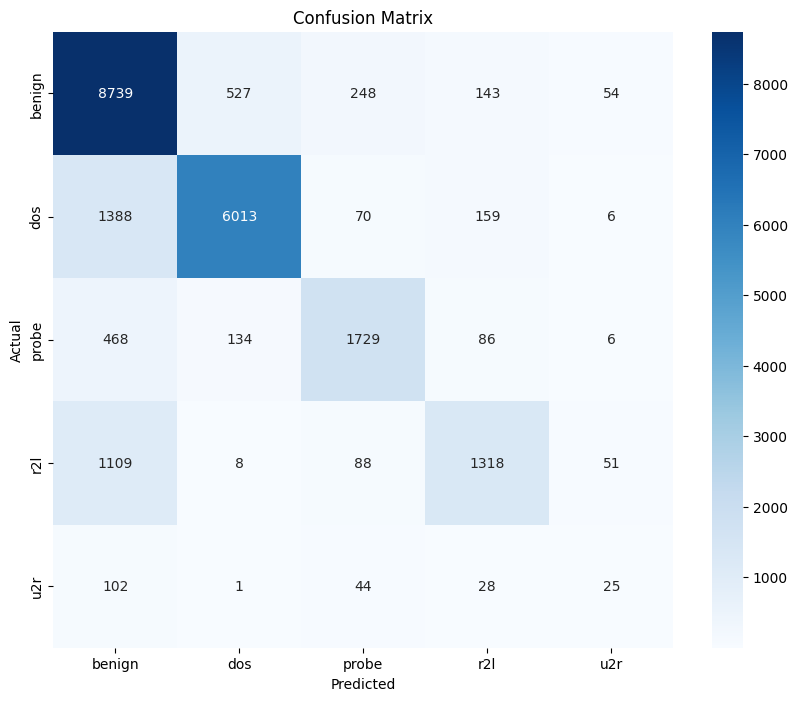

              precision    recall  f1-score   support

      benign       0.74      0.90      0.81      9711
         dos       0.90      0.79      0.84      7636
       probe       0.79      0.71      0.75      2423
         r2l       0.76      0.51      0.61      2574
         u2r       0.18      0.12      0.15       200

    accuracy                           0.79     22544
   macro avg       0.67      0.61      0.63     22544
weighted avg       0.80      0.79      0.79     22544

Zero-One Loss: 0.20936834634492552


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, zero_one_loss
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Center Loss Definition
class CenterLoss(nn.Module):
    def __init__(self, num_classes=5, feat_dim=121, use_gpu=True):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        self.use_gpu = use_gpu

        if self.use_gpu:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim).cuda())
        else:
            self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))

    def forward(self, x, labels):
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        if labels.dim() == 1:
            labels = labels.unsqueeze(1)
        labels = labels.expand(batch_size, self.num_classes)

        classes = torch.arange(self.num_classes).long()
        if self.use_gpu:
            classes = classes.cuda()
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# CNN Model Definition with Residual Blocks
class CNNModel(nn.Module):
    def __init__(self, input_shape, embedding_dim=121, num_classes=5):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, padding=1)

        # Adding Residual Blocks with reduced downsampling
        self.res_block1 = ResidualBlock(4, 16, stride=1)
        self.res_block2 = ResidualBlock(16, 64, stride=1)
        self.res_block3 = ResidualBlock(64, 121, stride=1)

        # Only one pooling layer after initial conv and res blocks
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the output after the residual blocks
        self._to_linear = None
        self.convs(torch.randn(1, *input_shape))

        self.fc = nn.Linear(self._to_linear, embedding_dim)
        self.classifier = nn.Linear(embedding_dim, num_classes)

    def convs(self, x):
        x = F.relu(self.conv1(x))           # Initial conv
        x = self.pool(x)                    # Pooling after initial conv
        x = self.res_block1(x)              # Residual block 1
        x = self.res_block2(x)              # Residual block 2
        x = self.res_block3(x)              # Residual block 3
        x = self.pool(x)                    # Pooling after res_block3

        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).shape[1]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)
        embeddings = F.relu(self.fc(x))
        outputs = self.classifier(embeddings)
        return embeddings, outputs

# Custom collate function to move data to device
def collate_fn(batch):
    data, target = zip(*batch)
    data = torch.stack(data).to(device)
    target = torch.tensor(target).to(device)
    return data, target

# Data Preparation
def prepare_data(device):
    # Assuming combined_df, train_df, and test_df are already defined
    # Example data preparation process
    train_x = combined_df[:len(train_x_raw)]
    test_x = combined_df[len(train_x_raw):]

    train_x.iloc[:, 37:118] = train_x.iloc[:, 37:118].astype(int)
    test_x.iloc[:, 37:118] = test_x.iloc[:, 37:118].astype(int)

    train_x = train_x.applymap(lambda x: np.log(x + 1))
    test_x = test_x.applymap(lambda x: np.log(x + 1))

    numeric_cols = train_x.columns[train_x.dtypes.apply(lambda c: np.issubdtype(c, np.number))]
    min_max_scaler = MinMaxScaler().fit(train_x[numeric_cols])

    train_x[numeric_cols] = min_max_scaler.transform(train_x[numeric_cols])
    test_x[numeric_cols] = min_max_scaler.transform(test_x[numeric_cols])

    pad_width = 121 - 118
    train_x = np.pad(train_x.values, ((0, 0), (0, pad_width)), mode='constant')
    test_x = np.pad(test_x.values, ((0, 0), (0, pad_width)), mode='constant')

    train_x = torch.tensor(train_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)
    test_x = torch.tensor(test_x.reshape(-1, 1, 11, 11), dtype=torch.float32).to(device)

    train_Y = train_df['attack_category']
    test_Y = test_df['attack_category']
    label_encoder = LabelEncoder()
    train_Y_int = label_encoder.fit_transform(train_Y)
    test_Y_int = label_encoder.transform(test_Y)

    train_Y = torch.tensor(train_Y_int, dtype=torch.long).to(device)
    test_Y = torch.tensor(test_Y_int, dtype=torch.long).to(device)

    train_dataset = TensorDataset(train_x, train_Y)
    test_dataset = TensorDataset(test_x, test_Y)
    return train_dataset, test_dataset, label_encoder

# Training Episode Function
def training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device):
    model.train()
    J = 0  # Initialize total loss
    episode_loss = 0  # Initialize loss for this episode
    count = 0  # Counter for number of iterations

    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    for class_label in range(num_classes):
        # Step 3: Select training examples from the training dataset
        Q_k = []
        Q_y = []
        for j in range(num_classes):
            train_indices = torch.where(train_loader.dataset.tensors[1] == j)[0]
            sampled_indices = train_indices[torch.randperm(len(train_indices))[:N_T]]
            Q_k.append(train_loader.dataset.tensors[0][sampled_indices])
            Q_y.append(train_loader.dataset.tensors[1][sampled_indices])
        Q_k = torch.cat(Q_k).to(device)
        Q_y = torch.cat(Q_y).to(device)

        # Compute the benchmark of embedding features
        with torch.no_grad():
            S_k_embeddings, _ = model(support_x)
        c_k = S_k_embeddings.mean(dim=0)

        for x, y in zip(Q_k, Q_y):
            x = x.unsqueeze(0)  # Reshape to match model input shape
            optimizer.zero_grad()
            embeddings, outputs = model(x)
            L_S = criterion(outputs, y.unsqueeze(0))
            L_C = center_loss_func(embeddings, y)
            loss = L_S + lambda_ * L_C
            loss.backward()
            optimizer.step()
            #J += (1 / (num_classes * len(train_loader) * len(Q_k))) * loss.item()
            episode_loss += loss.item()
            count += 1

    # Compute average loss for this episode
    average_loss = episode_loss / count
    print(f"Training loss for episode: {average_loss}")

    return average_loss

# Training Loop
def train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device):
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        final_loss = 0

        for _ in range(N_P):
            # Create support set from training data
            support_indices = []
            for class_label in range(num_classes):
                class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
                support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

            support_set = Subset(train_loader.dataset, support_indices)

            # Train for one episode
            episode_loss2 = training_episode(train_loader, support_set, model, center_loss_func, criterion, optimizer, N_T, lambda_, num_classes, device)
            final_loss += episode_loss2

        final_loss /= N_P
        print(f'Epoch {epoch + 1}/{epochs}, Average Loss: {final_loss}')


# Testing Phase Function
def test_phase(test_loader, support_set, model, device, label_encoder, batch_size=32, chunk_size=100):
    model.eval()
    test_x, test_Y = test_loader.dataset.tensors
    support_x, support_Y = support_set.tensors

    with torch.no_grad():
        # Compute embeddings for the support set
        support_embeddings, _ = model(support_x.to(device))

        # Compute embeddings for the test set in batches
        test_embeddings = []
        for i in range(0, len(test_x), batch_size):
            batch_x = test_x[i:i + batch_size].to(device)
            batch_embeddings, _ = model(batch_x)
            test_embeddings.append(batch_embeddings.cpu())

        test_embeddings = torch.cat(test_embeddings).to(device)

        # Compute similarities in chunks to avoid memory overflow
        similarities = []
        for i in range(0, len(test_embeddings), chunk_size):
            chunk_test_embeddings = test_embeddings[i:i + chunk_size]
            chunk_similarities = F.cosine_similarity(chunk_test_embeddings.unsqueeze(1), support_embeddings.unsqueeze(0), dim=-1)
            similarities.append(chunk_similarities.cpu())

        similarities = torch.cat(similarities).to(device)
        from sklearn.metrics import confusion_matrix, classification_report
        from sklearn.metrics import confusion_matrix, zero_one_loss

        # Get the predicted labels based on maximum similarity
        predicted_indices = similarities.argmax(dim=1)
        predicted_indices = predicted_indices.to(support_Y.device)
        predicted_labels = support_Y[predicted_indices].cpu().numpy()

        # Evaluate with confusion matrix
        conf_matrix = confusion_matrix(test_Y.cpu().numpy(), predicted_labels)

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_.tolist(), yticklabels=label_encoder.classes_.tolist())
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        # Print classification report
        print(classification_report(test_Y.cpu().numpy(), predicted_labels, target_names=label_encoder.classes_))

        # Print zero-one loss
        error = zero_one_loss(test_Y.cpu().numpy(), predicted_labels)
        print("Zero-One Loss:", error)

# Main Function
if __name__ == "__main__":
    # Hyperparameters
    N_T = 50  # Number of training samples per class
    N_S = 10  # Number of support samples per class
    lambda_ = 0
    epochs = 5
    batch_size = 32
    num_classes = 5
    input_shape = (1, 11, 11)
    embedding_dim = 121
    N_P = 10  # Number of sampling episodes

    # Prepare data
    train_dataset, test_dataset, label_encoder = prepare_data(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Initialize model, loss functions, and optimizer
    model = CNNModel(input_shape, embedding_dim, num_classes).to(device)
    center_loss_func = CenterLoss(num_classes=num_classes, feat_dim=embedding_dim, use_gpu=torch.cuda.is_available())
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(list(model.parameters()) + list(center_loss_func.parameters()), lr=0.001)

    # Train the model
    train(train_loader, model, center_loss_func, criterion, optimizer, epochs, N_T, N_S, lambda_, num_classes, N_P, device)

    # Create support set from training data for testing phase
    support_indices = []
    for class_label in range(num_classes):
        class_indices = torch.where(train_loader.dataset.tensors[1] == class_label)[0]
        support_indices.extend(class_indices[torch.randperm(len(class_indices))[:N_S]])

    support_x = train_loader.dataset.tensors[0][support_indices]
    support_Y = train_loader.dataset.tensors[1][support_indices]
    support_set = TensorDataset(support_x, support_Y)

    # Evaluate the model in the testing phase
    test_phase(test_loader, support_set, model, device, label_encoder)
